<a href="https://colab.research.google.com/github/Pamela-YC-Cheng/Supply-Chain-Analytics/blob/main/Biopharma_Network_Optimization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Biopharma

### Install and import packages for retrieving exchange rate


In [1]:
!pip install forex_python

from forex_python.converter import CurrencyRates
from datetime import datetime, timedelta

import numpy as np
from scipy.stats import multivariate_normal


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 137.9/137.9 kB 2.8 MB/s eta 0:00:00


In [2]:
# Install and import packages
!pip install gurobipy
!pip install tabulate

import pandas as pd
import gurobipy as gp
from gurobipy import Model, GRB, quicksum
from tabulate import tabulate
import datetime as dt
_empty_series = pd.Series(dtype=float)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.4/13.4 MB 49.1 MB/s eta 0:00:00


### Retrive the exhange rate

In [3]:
def get_monthly_exchange_rates(start_year, end_year, base_currency, target_currencies):
    c = CurrencyRates()
    rates = {currency: [] for currency in target_currencies}

    # Generate a list of first day of each month in the specified range
    start_date = datetime(start_year, 1, 1)
    end_date = datetime(end_year, 12, 31)
    current_date = start_date

    while current_date <= end_date:
        for currency in target_currencies:
            try:
                # Get exchange rate for the first day of the month
                rate = c.get_rate(base_currency, currency, current_date)
                rates[currency].append((current_date.strftime("%Y-%m"), rate))
            except Exception as e:
                print(f"Error fetching rate for {currency} on {current_date.strftime('%Y-%m')}: {e}")
                rates[currency].append((current_date.strftime("%Y-%m"), None))

        # Move to the first day of the next month
        if current_date.month == 12:
            current_date = datetime(current_date.year + 1, 1, 1)
        else:
            current_date = datetime(current_date.year, current_date.month + 1, 1)

    return rates

In [4]:
# Specify the currencies
base_currency = "USD"
target_currencies = ["BRL", "EUR", "INR", "JPY", "MXN"]

# Fetch exchange rates from Jan 2019 to Dec 2023
exchange_rates = get_monthly_exchange_rates(2019, 2023, base_currency, target_currencies)

# Print the rates
for currency, rates in exchange_rates.items():
    print(f"Exchange rates for {currency} against {base_currency}:")
    for date, rate in rates:
        print(f"{date}: {rate}")
    print("\n")

Exchange rates for BRL against USD:
2019-01: 3.8812227074235808
2019-02: 3.6709964257693315
2019-03: 3.7808134938065536
2019-04: 3.8771804912780348
2019-05: 3.9267249064004286
2019-06: 3.9872657160792757
2019-07: 3.8272094457661465
2019-08: 3.8255866630424937
2019-09: 4.157212758245742
2019-10: 4.164433841071756
2019-11: 3.989316814794865
2019-12: 4.230468038608632
2020-01: 4.0196724230016025
2020-02: 4.266829533116178
2020-03: 4.485014120433634
2020-04: 5.2440563277249455
2020-05: 5.384792203015815
2020-06: 5.3324937027707815
2020-07: 5.442857142857142
2020-08: 5.167032410533423
2020-09: 5.433052473512972
2020-10: 5.6008339006126615
2020-11: 5.779363993845102
2020-12: 5.311915106951871
2021-01: 5.193953223046206
2021-02: 5.442320423700762
2021-03: 5.579025968638513
2021-04: 5.631619274646687
2021-05: 5.346548584671412
2021-06: 5.202126789366054
2021-07: 4.960871760350051
2021-08: 5.1060465898578755
2021-09: 5.152407548447152
2021-10: 5.415172413793104
2021-11: 5.650889618241493
2021-1

In [5]:
# Convert the data into a NumPy array for analysis
# Note: This example assumes all currencies have the same number of rates and ignores missing values

# Extract rates for each currency, ensuring they're in the same order for each month
rates_list = [rates for rates in exchange_rates.values() if all(rate is not None for _, rate in rates)]
currency_data = np.array([[rate for _, rate in currency_rates] for currency_rates in rates_list])

# Transpose to get rows as observations (dates) and columns as variables (currencies)
currency_data = currency_data.T

# Ensure no NaN values; this method requires complete data
if np.isnan(currency_data).any():
    print("Data contains NaN values. Please handle missing data before proceeding.")
else:
    # Estimate the mean and covariance
    mean_vector = np.mean(currency_data, axis=0)
    covariance_matrix = np.cov(currency_data, rowvar=False)

    # Fit the multivariate normal distribution
    mvn_distribution = multivariate_normal(mean=mean_vector, cov=covariance_matrix)


    print("Mean Vector:\n", mean_vector)
    print("Covariance Matrix:\n", covariance_matrix)
    # The distribution is now defined and can be used for further analysis

Mean Vector:
 [  4.91679403   0.89791993  75.7301565  119.26608249  19.81262121]
Covariance Matrix:
 [[ 3.42594387e-01 -2.13708474e-03  1.22952065e+00  1.27836101e+00
   3.46111090e-01]
 [-2.13708474e-03  2.17002114e-03  1.24913080e-01  5.21137097e-01
  -1.73246912e-02]
 [ 1.22952065e+00  1.24913080e-01  2.02929685e+01  6.06245515e+01
  -2.53203458e+00]
 [ 1.27836101e+00  5.21137097e-01  6.06245515e+01  2.26189966e+02
  -1.36106797e+01]
 [ 3.46111090e-01 -1.73246912e-02 -2.53203458e+00 -1.36106797e+01
   2.22048686e+00]]


### Got the 100 samples

In [22]:
# Change the size to 100
sample = mvn_distribution.rvs(size=100, random_state=42)
sample = pd.DataFrame(sample, columns = ["BRL", "EUR", "INR", "JPY", "MXN"])
sample['USD'] = 1
print(sample)

         BRL       EUR        INR         JPY        MXN  USD
0   5.339033  0.866244  73.119811  111.976947  20.647650    1
1   5.610633  0.929650  79.345561  122.173290  21.555964    1
2   4.158135  0.914179  76.785541  126.464114  19.359696    1
3   4.231257  0.913227  76.098870  128.222328  18.853919    1
4   4.221797  0.860101  69.368990   97.334656  21.080869    1
..       ...       ...        ...         ...        ...  ...
95  6.213829  0.886242  77.527642  122.822677  20.152830    1
96  4.396904  0.859546  75.069506  121.384236  17.492399    1
97  5.186395  0.923140  80.662290  140.793295  16.972230    1
98  5.357669  0.935326  78.511699  118.709868  21.078569    1
99  4.076926  0.866398  71.729788  111.603781  19.358894    1

[100 rows x 6 columns]


### Install and import packages for optimized decision(Gurobi)

### Raw Data

In [7]:
selected_yr = 2023
base_yr = 2019

demand = pd.DataFrame({
    'from': ['LatinAmerica', 'Europe', 'AsiaWoJapan', 'Japan', 'Mexico', 'U.S.'],
    'd_h': [  7, 15,  5,  7,  3, 18],
    'd_r': [  7, 12,  3,  8,  3, 17],
})
demand.set_index('from', inplace=True)

caps = pd.DataFrame({
    'plant': ['Brazil', 'Germany', 'India', 'Japan', 'Mexico', 'U.S.'],
    'cap': [18, 45, 18, 10, 30, 22],
})
caps.set_index('plant', inplace=True)

pcosts = pd.DataFrame({
    'plant': ['Brazil', 'Germany', 'India', 'Japan', 'Mexico', 'U.S.'],
    'fc_p': [20, 45, 14, 13, 30, 23],
    'fc_h': [ 5, 13,  3,  4,  6,  5],
    'fc_r': [ 5, 13,  3,  4,  6,  5],
    'rm_h': [3.6, 3.9, 3.6, 3.9, 3.6, 3.6],
    'pc_h': [5.1, 6.0, 4.5, 6.0, 5.0, 5.0],
    'rm_r': [4.6, 5.0, 4.5, 5.1, 4.6, 4.5],
    'pc_r': [6.6, 7.0, 6.0, 7.0, 6.5, 6.5],
})
pcosts.set_index('plant', inplace=True)

tcosts = pd.DataFrame({
    'from': ['Brazil', 'Germany', 'India', 'Japan', 'Mexico', 'U.S.'],
    'LatinAmerica': [ 0.20, 0.45, 0.50, 0.50, 0.40, 0.45],
    'Europe':       [ 0.45, 0.20, 0.35, 0.40, 0.30, 0.30],
    'AsiaWoJapan':  [ 0.50, 0.35, 0.20, 0.30, 0.50, 0.45],
    'Japan':        [ 0.50, 0.40, 0.30, 0.10, 0.45, 0.45],
    'Mexico':       [ 0.40, 0.30, 0.50, 0.45, 0.20, 0.25],
    'U.S.':           [ 0.45, 0.30, 0.45, 0.45, 0.25, 0.20],
})
tcosts.set_index('from', inplace=True)

duties = pd.DataFrame({
    'from': ['LatinAmerica', 'Europe', 'AsiaWoJapan', 'Japan', 'Mexico', 'U.S.'],
    'duty': [ 0.30, 0.03, 0.27, 0.06, 0.35, 0.04],
})
duties.set_index('from', inplace=True)

# Your provided exchange_rate_data
exrate0 = sample
exrate0

,BRL,EUR,INR,JPY,MXN,USD
0,5.339033,0.866244,73.119811,111.976947,20.647650,1
1,5.610633,0.929650,79.345561,122.173290,21.555964,1
2,4.158135,0.914179,76.785541,126.464114,19.359696,1
3,4.231257,0.913227,76.098870,128.222328,18.853919,1
4,4.221797,0.860101,69.368990,97.334656,21.080869,1
...,...,...,...,...,...,...
95,6.213829,0.886242,77.527642,122.822677,20.152830,1
96,4.396904,0.859546,75.069506,121.384236,17.492399,1
97,5.186395,0.923140,80.662290,140.793295,16.972230,1
98,5.357669,0.935326,78.511699,118.709868,21.078569,1


# Minimize cost using Gurobi Binary and Integer optimizer

## Functions to calculate cost, unmet demand, and excess capacity

In [8]:
# identify number of supply and demand location for iterations
n_ctry = range(demand.shape[0])
n_lines = range(demand.shape[1]+1)

# Objective function to calculate cost
def calc_total_cost(dec_plant, dec_h, dec_r, sample_rows, tariff=0):
    x_plant = np.array(list(dec_plant.values())).reshape(len(n_ctry), len(n_lines))
    x_h = np.array(list(dec_h.values())).reshape(len(n_ctry), len(n_ctry))
    x_r = np.array(list(dec_r.values())).reshape(len(n_ctry), len(n_ctry))

    # Adjust the cost using exchange rate of give year
    ba_yr = [4.33, 0.92, 71.48, 109.82, 18.65, 1]
    reindx = np.array(ba_yr) / sample_rows.values

    pcosts_rev = pcosts.values * reindx.reshape(-1,1)
    pcosts_rev = pd.DataFrame(pcosts_rev, columns=pcosts.columns[0:], index=pcosts.index)
    # return pcosts_rev
    # pcosts_rev = adj_pcosts_exrate(2019, 2023)

    duties_mat = np.zeros(len(duties)) + (1 + duties['duty'].values)[:, np.newaxis]
    np.fill_diagonal(duties_mat, 1)
    duties_mat = pd.DataFrame(duties_mat.T, index=pcosts_rev.index, columns=duties.index)
    duties_mat.loc['Germany', 'U.S.'] += tariff
    duties_mat.loc['U.S.', 'Europe']  += tariff

    vcosts_h = tcosts.add(pcosts_rev['rm_h'], axis=0).add(pcosts_rev['pc_h'], axis=0) * duties_mat
    vcosts_r = tcosts.add(pcosts_rev['rm_r'], axis=0).add(pcosts_rev['pc_r'], axis=0) * duties_mat

    fc = pcosts_rev[['fc_p','fc_h','fc_r']].values
    vh = (vcosts_h * x_h).values
    vr = (vcosts_r * x_r).values
    total_cost = sum(0.2 * fc[i,j] for i in n_ctry for j in n_lines) + sum(0.8 * fc[i,j] * x_plant[i,j] for i in n_ctry for j in n_lines) + sum(vh[i,j] for i in n_ctry for j in n_ctry) + sum(vr[i,j] for i in n_ctry for j in n_ctry)

    return total_cost


# Calculate excess capacity given decision variables
def calc_excess_cap(dec_plant, dec_h, dec_r):
    x_plant = np.array(list(dec_plant.values())).reshape(len(n_ctry), len(n_lines))
    x_h = np.array(list(dec_h.values())).reshape(len(n_ctry), len(n_ctry))
    x_r = np.array(list(dec_r.values())).reshape(len(n_ctry), len(n_ctry))

    excess_cap = (x_plant * caps.values).copy()
    excess_cap[:, 0] -= (np.sum(x_h, axis=1) + np.sum(x_r, axis=1))
    excess_cap[:, 1] -= np.sum(x_h, axis=1)
    excess_cap[:, 2] -= np.sum(x_r, axis=1)
    return excess_cap

# Calculate unmet demand given decision variables
def calc_unmet_demand(dec_h, dec_r):
    x_h = np.array(list(dec_h.values())).reshape(len(n_ctry), len(n_ctry))
    x_r = np.array(list(dec_r.values())).reshape(len(n_ctry), len(n_ctry))

    x_h_sum = np.sum(x_h, axis=0)
    x_r_sum = np.sum(x_r, axis=0)
    unmet_demand = (demand.values).copy()
    unmet_demand = np.column_stack((x_h_sum - unmet_demand[:, 0], x_r_sum - unmet_demand[:, 1]))

    return unmet_demand


## Gurobi optimizer

# Question1:

In [9]:
# Create a Gurobi model
model = Model("MinimizeCost")

# Assign initial value of decision variables
dec_plant = {(i, j): 1 for i in n_ctry for j in n_lines}
dec_h     = {(i, j): 1 for i in n_ctry for j in n_ctry}
dec_r     = {(i, j): 1 for i in n_ctry for j in n_ctry}

# Define decision variables
dec_plant = {(i, j): model.addVar(vtype=GRB.BINARY, name=f"Dec_plant_{i}_{j}")    for i in n_ctry for j in n_lines}
dec_h     = {(i, j): model.addVar(vtype=GRB.CONTINUOUS, lb=0, name=f"Dec_h_{i}_{j}") for i in n_ctry for j in n_ctry}
dec_r     = {(i, j): model.addVar(vtype=GRB.CONTINUOUS, lb=0, name=f"Dec_r_{i}_{j}") for i in n_ctry for j in n_ctry}

# Update parameters in the model based on the current draw
# Excess Capacity constraints
excess_cap = calc_excess_cap(dec_plant, dec_h, dec_r)
for i in n_ctry:
  for j in n_lines:
    model.addConstr(excess_cap[i, j] >= 0, name=f"Excess_Cap_Constraints_{i}_{j}")

# Unmet demand constraints
unnmet_demand = calc_unmet_demand(dec_h, dec_r)
for i in n_ctry:
  for j in range(2):
    model.addConstr(unnmet_demand[i,j] == 0, name=f"Unmet_Demand_Constraints_{i}_{j}")

# Update the model
model.update()

# Set objective function - Total cost = Fixed cost + Variable costs of Highcal and Relax lines
for index, sample_rows in sample.iterrows():
  model.setObjective(calc_total_cost(dec_plant, dec_h, dec_r, sample_rows, tariff = 0), GRB.MINIMIZE)
# Suppress optimization output
  model.Params.OutputFlag = 0
# Optimize the model
  model.optimize()


  # Extract results to print as table
  op_plant = pd.DataFrame([[dec_plant[i, j].x for j in n_lines] for i in n_ctry], columns = ['Plant','H','R'], index=caps.index)
  op_h     = pd.DataFrame([[dec_h[i, j].x for j in n_ctry] for i in n_ctry], columns = tcosts.columns, index=tcosts.index)
  op_r     = pd.DataFrame([[dec_r[i, j].x for j in n_ctry] for i in n_ctry], columns = tcosts.columns, index=tcosts.index)


  print("\nStrategy\n")
  print(tabulate(op_plant, headers='keys', tablefmt='pretty'))
  print("\nHighCal Flow\n")
  print(tabulate(op_h, headers='keys', tablefmt='pretty'))
  print("\nRelax Flow\n")
  print(tabulate(op_r, headers='keys', tablefmt='pretty'))
  print(f"\nMinimum Cost: $ {model.objVal}")
  print(f"\nSelected exchange rate: \n{sample_rows}")

串流輸出內容已截斷至最後 5000 行。

Strategy

+---------+-------+-----+-----+
|  plant  | Plant |  H  |  R  |
+---------+-------+-----+-----+
| Brazil  |  1.0  | 1.0 | 1.0 |
| Germany |  1.0  | 0.0 | 1.0 |
|  India  |  1.0  | 1.0 | 1.0 |
|  Japan  |  1.0  | 0.0 | 1.0 |
| Mexico  |  1.0  | 1.0 | 1.0 |
|  U.S.   |  1.0  | 1.0 | 0.0 |
+---------+-------+-----+-----+

HighCal Flow

+---------+--------------+--------+-------------+-------+--------+------+
|  from   | LatinAmerica | Europe | AsiaWoJapan | Japan | Mexico | U.S. |
+---------+--------------+--------+-------------+-------+--------+------+
| Brazil  |     7.0      |  0.0   |     0.0     |  0.0  |  0.0   | 0.0  |
| Germany |     0.0      |  0.0   |     0.0     |  0.0  |  0.0   | 0.0  |
|  India  |     0.0      |  3.0   |     5.0     |  7.0  |  0.0   | 0.0  |
|  Japan  |     0.0      |  0.0   |     0.0     |  0.0  |  0.0   | 0.0  |
| Mexico  |     0.0      |  8.0   |     0.0     |  0.0  |  3.0   | 0.0  |
|  U.S.   |     0.0      |  4.0   |     0

In [10]:
# Summary table
count_summary = pd.DataFrame(0, index=n_ctry, columns=['Plant', 'H', 'R'])

for index, sample_rows in sample.iterrows():
    model.setObjective(calc_total_cost(dec_plant, dec_h, dec_r, sample_rows, tariff = 0), GRB.MINIMIZE)
    model.Params.OutputFlag = 0
    model.optimize()

    if model.status == GRB.OPTIMAL:
        op_plant = pd.DataFrame([[dec_plant[i, j].X for j in n_lines] for i in n_ctry], index=n_ctry, columns=['Plant', 'H', 'R'])
        for country in n_ctry:
            count_summary.loc[country, 'H'] += op_plant.loc[country, 'H']
            count_summary.loc[country, 'R'] += op_plant.loc[country, 'R']

count_summary['Country'] = ['Brazil', 'Germany', 'India', 'Japan', 'Mexico', 'U.S.']
count_summary = count_summary[['Country', 'H', 'R']]

print(tabulate(count_summary, headers='keys', tablefmt='pretty'))

+---+---------+-----+-----+
|   | Country |  H  |  R  |
+---+---------+-----+-----+
| 0 | Brazil  | 99  | 99  |
| 1 | Germany | 23  | 79  |
| 2 |  India  | 100 | 100 |
| 3 |  Japan  |  8  | 72  |
| 4 | Mexico  | 95  | 95  |
| 5 |  U.S.   | 82  | 22  |
+---+---------+-----+-----+


In [11]:
strategy_counts = {}

for index, sample_rows in sample.iterrows():
    model.setObjective(calc_total_cost(dec_plant, dec_h, dec_r, sample_rows, tariff = 0), GRB.MINIMIZE)
    model.Params.OutputFlag = 0
    model.optimize()
    chosen_strategy = str([0.0 if x == -0.0 else x for i in n_ctry for j in n_lines for x in [dec_plant[i, j].x]])

    # Update strategy count
    if chosen_strategy in strategy_counts:
        strategy_counts[chosen_strategy] += 1
    else:
        strategy_counts[chosen_strategy] = 1

In [12]:
# Create a DataFrame from the strategy counts
df_strategies = pd.DataFrame(list(strategy_counts.items()), columns=['Strategy', 'Count'])

# Sort the DataFrame by 'Count' in descending order and keep the top 3
df_top_strategies = df_strategies.sort_values(by='Count', ascending=False).head(3)

# Display the sorted DataFrame with top 3 strategies
print(df_top_strategies.head())

                                            Strategy  Count
0  [1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, ...     40
2  [1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, ...     18
1  [1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, ...      9


In [13]:

# Example strategies dictionary structure (based on your original extraction)
strategies = {
    "Strategy0": {"values": [1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0], "count": 40},
    "Strategy2": {"values": [1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0], "count": 16},
    "Strategy7": {"values": [1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0], "count": 10}
}

# Define countries and labels
countries = ['Brazil', 'Germany', 'India', 'Japan', 'Mexico', 'U.S.']
labels = ['Plant', 'H', 'R']

# Create the DataFrame columns
columns = [f'{country} {label}' for country in countries for label in labels]
columns.append('Count')  # Add 'Count' to the end

# Prepare the data for the DataFrame
data = []
for strategy, details in strategies.items():
    row = details["values"]  # This is already a list of values corresponding to the columns
    row.append(details["count"])  # Append the count to the row
    data.append(row)

# Create the DataFrame
top3_table = pd.DataFrame(data, columns=columns)

# Display the DataFrame
top3_table.head()


,Brazil Plant,Brazil H,Brazil R,Germany Plant,Germany H,Germany R,India Plant,India H,India R,Japan Plant,Japan H,Japan R,Mexico Plant,Mexico H,Mexico R,U.S. Plant,U.S. H,U.S. R,Count
0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,40
1,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,16
2,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,10


# Question 2:

Based on the result, we thus can propose three network strategies:
1. First Strategy: Flexible strategy(Chained Strategy).
We will open plant in all country to supply the demand of the region.
Germany and Japan will not produce Highcal, and US will not produce Relax.

+---------+-------+-----+-----+
|  plant  | Plant |  H  |  R  |
+---------+-------+-----+-----+
| Brazil  |  1.0  | 1.0 | 1.0 |
| Germany |  1.0  | 0.0 | 1.0 |
|  India  |  1.0  | 1.0 | 1.0 |
|  Japan  |  1.0  | 0.0 | 1.0 |
| Mexico  |  1.0  | 1.0 | 1.0 |
|  U.S.   |  1.0  | 1.0 | 0.0 |
+---------+-------+-----+-----+

HighCal Flow

+---------+--------------+--------+-------------+-------+--------+------+
|  from   | LatinAmerica | Europe | AsiaWoJapan | Japan | Mexico | U.S. |
+---------+--------------+--------+-------------+-------+--------+------+
| Brazil  |     7.0      |  0.0   |     0.0     |  0.0  |  0.0   | 0.0  |
| Germany |     0.0      |  0.0   |     0.0     |  0.0  |  0.0   | 0.0  |
|  India  |     0.0      |  3.0   |     5.0     |  7.0  |  0.0   | 0.0  |
|  Japan  |     0.0      |  0.0   |     0.0     |  0.0  |  0.0   | 0.0  |
| Mexico  |     0.0      |  8.0   |     0.0     |  0.0  |  3.0   | 0.0  |
|  U.S.   |     0.0      |  4.0   |     0.0     |  0.0  |  0.0   | 18.0 |
+---------+--------------+--------+-------------+-------+--------+------+

Relax Flow

+---------+--------------+--------+-------------+-------+--------+------+
|  from   | LatinAmerica | Europe | AsiaWoJapan | Japan | Mexico | U.S. |
+---------+--------------+--------+-------------+-------+--------+------+
| Brazil  |     7.0      |  3.0   |     0.0     |  0.0  |  0.0   | 1.0  |
| Germany |     0.0      |  7.0   |     0.0     |  0.0  |  0.0   | 0.0  |
|  India  |     0.0      |  0.0   |     3.0     |  0.0  |  0.0   | 0.0  |
|  Japan  |     0.0      |  2.0   |     0.0     |  8.0  |  0.0   | 0.0  |
| Mexico  |     0.0      |  0.0   |     0.0     |  0.0  |  3.0   | 16.0 |
|  U.S.   |     0.0      |  0.0   |     0.0     |  0.0  |  0.0   | 0.0  |
+---------+--------------+--------+-------------+-------+--------+------+

---
The second strategy: Full Flexibility strategy
Plant will not be opend in Japan.
Germany will not produce any Highcal, and US will not produce Relax.

+---------+-------+-----+-----+
|  plant  | Plant |  H  |  R  |
+---------+-------+-----+-----+
| Brazil  |  1.0  | 1.0 | 1.0 |
| Germany |  1.0  | 0.0 | 1.0 |
|  India  |  1.0  | 1.0 | 1.0 |
|  Japan  |  0.0  | 0.0 | 0.0 |
| Mexico  |  1.0  | 1.0 | 1.0 |
|  U.S.   |  1.0  | 1.0 | 0.0 |
+---------+-------+-----+-----+

HighCal Flow

+---------+--------------+--------+-------------+-------+--------+------+
|  from   | LatinAmerica | Europe | AsiaWoJapan | Japan | Mexico | U.S. |
+---------+--------------+--------+-------------+-------+--------+------+
| Brazil  |     7.0      |  0.0   |     0.0     |  0.0  |  0.0   | 0.0  |
| Germany |     0.0      |  0.0   |     0.0     |  0.0  |  0.0   | 0.0  |
|  India  |     0.0      |  0.0   |     5.0     |  7.0  |  0.0   | 0.0  |
|  Japan  |     0.0      |  0.0   |     0.0     |  0.0  |  0.0   | 0.0  |
| Mexico  |     0.0      |  11.0  |     0.0     |  0.0  |  3.0   | 0.0  |
|  U.S.   |     0.0      |  4.0   |     0.0     |  0.0  |  0.0   | 18.0 |
+---------+--------------+--------+-------------+-------+--------+------+

Relax Flow

+---------+--------------+--------+-------------+-------+--------+------+
|  from   | LatinAmerica | Europe | AsiaWoJapan | Japan | Mexico | U.S. |
+---------+--------------+--------+-------------+-------+--------+------+
| Brazil  |     7.0      |  0.0   |     0.0     |  4.0  |  0.0   | 0.0  |
| Germany |     0.0      |  12.0  |     0.0     |  1.0  |  0.0   | 4.0  |
|  India  |     0.0      |  0.0   |     3.0     |  3.0  |  0.0   | 0.0  |
|  Japan  |     0.0      |  0.0   |     0.0     |  0.0  |  0.0   | 0.0  |
| Mexico  |     0.0      |  0.0   |     0.0     |  0.0  |  3.0   | 13.0 |
|  U.S.   |     0.0      |  0.0   |     0.0     |  0.0  |  0.0   | 0.0  |
+---------+--------------+--------+-------------+-------+--------+------+


---
The third strategy is also a Chained Strategy:
Plants will be opened in each country.
Japan and the US won't produce Highcal.
Germany won't produce Relax.

+---------+-------+-----+-----+
|  plant  | Plant |  H  |  R  |
+---------+-------+-----+-----+
| Brazil  |  1.0  | 1.0 | 1.0 |
| Germany |  1.0  | 1.0 | 0.0 |
|  India  |  1.0  | 1.0 | 1.0 |
|  Japan  |  1.0  | 0.0 | 1.0 |
| Mexico  |  1.0  | 1.0 | 1.0 |
|  U.S.   |  1.0  | 0.0 | 1.0 |
+---------+-------+-----+-----+

HighCal Flow

+---------+--------------+--------+-------------+-------+--------+------+
|  from   | LatinAmerica | Europe | AsiaWoJapan | Japan | Mexico | U.S. |
+---------+--------------+--------+-------------+-------+--------+------+
| Brazil  |     7.0      |  0.0   |     0.0     |  0.0  |  0.0   | 0.0  |
| Germany |     0.0      |  7.0   |     0.0     |  0.0  |  0.0   | 0.0  |
|  India  |     0.0      |  2.0   |     5.0     |  7.0  |  0.0   | 0.0  |
|  Japan  |     0.0      |  0.0   |     0.0     |  0.0  |  0.0   | 0.0  |
| Mexico  |     0.0      |  6.0   |     0.0     |  0.0  |  3.0   | 18.0 |
|  U.S.   |     0.0      |  0.0   |     0.0     |  0.0  |  0.0   | 0.0  |
+---------+--------------+--------+-------------+-------+--------+------+

Relax Flow

+---------+--------------+--------+-------------+-------+--------+------+
|  from   | LatinAmerica | Europe | AsiaWoJapan | Japan | Mexico | U.S. |
+---------+--------------+--------+-------------+-------+--------+------+
| Brazil  |     7.0      |  4.0   |     0.0     |  0.0  |  0.0   | 0.0  |
| Germany |     0.0      |  0.0   |     0.0     |  0.0  |  0.0   | 0.0  |
|  India  |     0.0      |  1.0   |     3.0     |  0.0  |  0.0   | 0.0  |
|  Japan  |     0.0      |  2.0   |     0.0     |  8.0  |  0.0   | 0.0  |
| Mexico  |     0.0      |  0.0   |     0.0     |  0.0  |  3.0   | 0.0  |
|  U.S.   |     0.0      |  5.0   |     0.0     |  0.0  |  0.0   | 17.0 |
+---------+--------------+--------+-------------+-------+--------+------+

In [23]:
# Initialize an empty list to hold strategy data for each scenario
strategy_data = []

# Iterate over each sample row to run the optimization and collect strategies
for index, sample_rows in sample.iterrows():
    model.setObjective(calc_total_cost(dec_plant, dec_h, dec_r, sample_rows, tariff = 0), GRB.MINIMIZE)
    model.Params.OutputFlag = 0
    model.optimize()
    # Directly create a list of strategies for the current scenario
    current_strategy = [0.0 if x == -0.0 else x for i in n_ctry for j in n_lines for x in [dec_plant[i, j].x]]
    strategy_data.append(current_strategy)

countries = ['Brazil', 'Germany', 'India', 'Japan', 'Mexico', 'U.S.']
labels = ['Plant', 'H', 'R']
# Create a DataFrame from the collected strategy data
strategy_df = pd.DataFrame(strategy_data, columns=[f'{country} {label}' for country in countries for label in labels])

strategy_df.head()

,Brazil Plant,Brazil H,Brazil R,Germany Plant,Germany H,Germany R,India Plant,India H,India R,Japan Plant,Japan H,Japan R,Mexico Plant,Mexico H,Mexico R,U.S. Plant,U.S. H,U.S. R
0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0
1,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0
2,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0
3,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0
4,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0


In [15]:
r= strategy_df.sum()
r

Brazil Plant      99.0
Brazil H          99.0
Brazil R          99.0
Germany Plant    100.0
Germany H         23.0
Germany R         79.0
India Plant      100.0
India H          100.0
India R          100.0
Japan Plant       72.0
Japan H            8.0
Japan R           72.0
Mexico Plant      95.0
Mexico H          95.0
Mexico R          95.0
U.S. Plant        94.0
U.S. H            82.0
U.S. R            22.0
dtype: float64

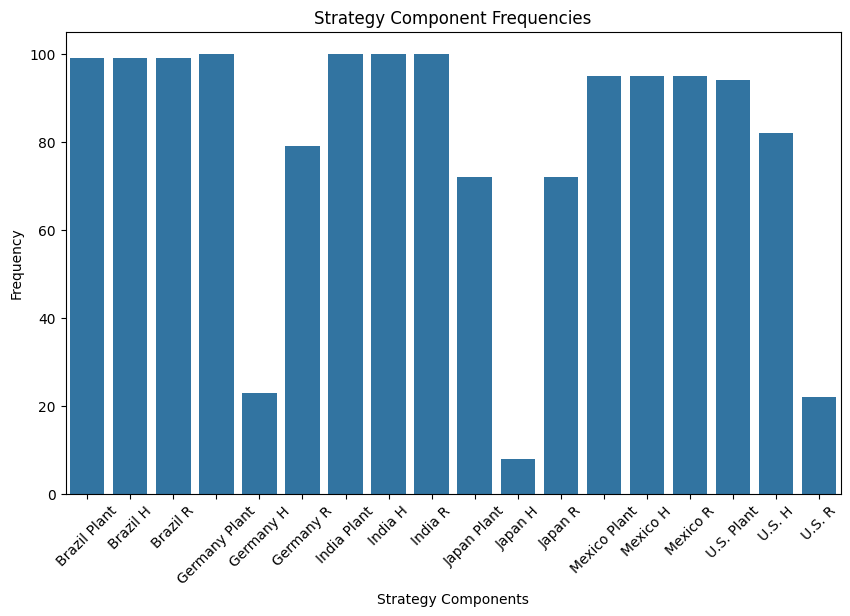

In [16]:
import seaborn as sns
import matplotlib.pyplot as plt

strategy_sums = strategy_df.sum()

# Creating the bar plot
plt.figure(figsize=(10, 6))
sns.barplot(x=strategy_sums.index, y=strategy_sums.values)
plt.xticks(rotation=45)
plt.title('Strategy Component Frequencies')
plt.ylabel('Frequency')
plt.xlabel('Strategy Components')
plt.show()

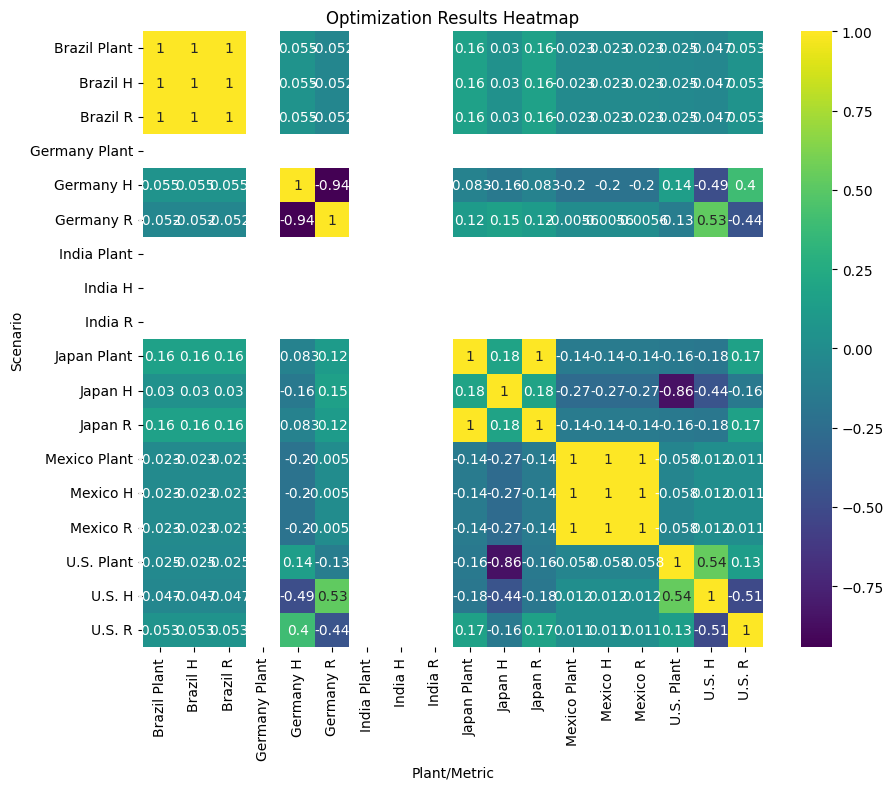

In [17]:
strategy_corr = strategy_df.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(strategy_corr, annot=True, cmap='viridis') # 'annot=True' to annotate cells, 'cmap' for color map
plt.title('Optimization Results Heatmap')
plt.ylabel('Scenario')
plt.xlabel('Plant/Metric')
plt.show()

The most recommended strategy is our first strategy

In [24]:
best_strategies = [[1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0],
                   [1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0],
                   [1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0]]

model = Model("MinimizeCost")

dec_h     = {(i, j): 1 for i in n_ctry for j in n_ctry}
dec_r     = {(i, j): 1 for i in n_ctry for j in n_ctry}

dec_plant = {(i, j): model.addVar(vtype=GRB.BINARY, name=f"Dec_plant_{i}_{j}")    for i in n_ctry for j in n_lines}
dec_h     = {(i, j): model.addVar(vtype=GRB.CONTINUOUS, lb=0, name=f"Dec_h_{i}_{j}") for i in n_ctry for j in n_ctry}
dec_r     = {(i, j): model.addVar(vtype=GRB.CONTINUOUS, lb=0, name=f"Dec_r_{i}_{j}") for i in n_ctry for j in n_ctry}

excess_cap = calc_excess_cap(dec_plant, dec_h, dec_r)
for i in n_ctry:
    for j in n_lines:
      model.addConstr(excess_cap[i, j] >= 0, name=f"Excess_Cap_Constraints_{i}_{j}")

unnmet_demand = calc_unmet_demand(dec_h, dec_r)
for i in n_ctry:
  for j in range(2):
    model.addConstr(unnmet_demand[i,j] == 0, name=f"Unmet_Demand_Constraints_{i}_{j}")

# Iterate over each strategy
for strategy_index, current_strategy in enumerate(best_strategies):

    # Set the decision variable bounds according to the current strategy
    for var_index, (plant_line, decision_var) in enumerate(dec_plant.items()):
        decision_var.lb = current_strategy[var_index]
        decision_var.ub = current_strategy[var_index]

    # List to store the cost for the current strategy across all scenarios
    strategy_costs = []

    for index, sample_rows in sample.iterrows():
        model.setObjective(calc_total_cost(dec_plant, dec_h, dec_r, sample_rows, tariff = 0), GRB.MINIMIZE)
        model.update()
        model.Params.OutputFlag = 0
        model.optimize()

        # Check if the model found an optimal solution and record the cost
        if model.status == GRB.OPTIMAL:
            strategy_costs.append(model.ObjVal)

    # Calculate the expected cost and its standard deviation for the current strategy
    strategy_expected_cost = np.mean(strategy_costs)
    strategy_cost_std = np.std(strategy_costs)

    print(f"Strategy {strategy_index + 1}: Expected Cost = {strategy_expected_cost}, Cost Std Dev = {strategy_cost_std}")

Strategy 1: Expected Cost = 1216.6967365814662, Cost Std Dev = 48.980559424343824
Strategy 2: Expected Cost = 1221.1405900602608, Cost Std Dev = 46.5883468290778
Strategy 3: Expected Cost = 1218.6420442699368, Cost Std Dev = 47.72906214400432
